<a href="https://colab.research.google.com/github/Biglasagna/Repo_test/blob/main/Projet_Diabete_UE_Bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Proposition d'un modèle de deep learning pour la classification patients/contrôles pour le diabète de type 2 à partir de données phénotypiques.
---


## introduction

Le diabète de type

Etapes du code :

* Présentation des données
* Visualisation des données
* Préparation des données
* Création du modèle et entrainement
* Visualisation de l'entrainement
* Test
* Visualisation des résultats

## Chargement des données de l'environnement local vers le drive pour un accès en ligne.




In [ ]:
import os
import pandas as pd
import io

# Monter le drive Google (ceci vous demandera d'autoriser l'accès à votre compte)
from google.colab import drive
drive.mount('/content/drive')

# Installer la bibliothèque gdown si ce n'est pas déjà fait
!pip install -q gdown

import gdown

# Extraction de l'ID du fichier depuis l'URL
file_id = '17UIROFJVhc-4sMv9BSEvQ8A7HCI-0kkt'
# Construction de l'URL de téléchargement direct
url = f'https://drive.google.com/uc?id={file_id}'

# Spécifier le chemin de sauvegarde sur le drive personnel
output_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Vérifier si le fichier existe déjà
if not os.path.exists(output_path):
    print("Téléchargement en cours...")
    gdown.download(url, output_path, quiet=False)
else:
    print("Le fichier existe déjà. Téléchargement annulé.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le fichier existe déjà. Téléchargement annulé.


In [ ]:
import pandas as pd
from google.colab import drive

# Step 1: Mount Google Drive to Colab
drive.mount('/content/drive')

# Step 2: Define the path to the file in Google Drive
file_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Step 3: Load the file into a pandas DataFrame
data = pd.read_csv(file_path, sep='\t')  # Load the file with tab separator
print(data.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   gene.id  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0        1   47.3396   24.0458    2.2743       0.0       0.0       0.0   
1        2    0.0000    0.0000    0.0000       0.0       0.0       0.0   
2        3    0.0000    0.0000    0.0000       0.0       0.0       0.0   

   Sample_7  Sample_8  Sample_9  ...  Sample_1591  Sample_1592  Sample_1593  \
0       0.0     0.000       0.0  ...          0.0       0.3304       2.4857   
1       0.0     0.254       0.0  ...          0.0       0.0000       0.0000   
2       0.0     0.000       0.0  ...          0.0       0.0000       0.0000   

   Sample_1594  Sample_1595  Sample_1596  Sample_1597  Sample_1598  \
0          0.0       8.1498          0.0       0.5372      31.1225   
1          0.0       0.0000          0.0       0.0000       0.0000   
2          0.0       0.0000          0.0       

## Transformation des données pour garder les "features" (ici les gènes) en colonnes et les individus en ligne, format sur lequel les librairies de deep learning sont basées. Création de la colonne "Label" pour la supervisation de l'apprentissage (0 pour contrôles et 1 pour patients).

In [ ]:
# Définir 'gene.id' comme index
data.set_index('gene.id', inplace=True)

data_transposed = data.T  # Transpose the DataFrame
data_transposed['Label'] = [0 if i < 653 else 1 for i in range(len(data_transposed))]

# Verify the transposed data
print(data_transposed.head())

gene.id         1    2    3         9   10   11       12   13        14   15  \
Sample_1  47.3396  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0   31.2047  0.0   
Sample_2  24.0458  0.0  0.0    0.0000  0.0  0.0  14.0425  0.0    0.0000  0.0   
Sample_3   2.2743  0.0  0.0    0.0000  0.0  0.0   0.8412  0.0    7.8214  0.0   
Sample_4   0.0000  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000  0.0   
Sample_5   0.0000  0.0  0.0  130.9796  0.0  0.0   0.0000  0.0  120.6832  0.0   

gene.id   ...  101929767  101929768  101929769  101929770  101929771  \
Sample_1  ...     5.1983        0.0        0.0        0.0        0.0   
Sample_2  ...     0.1064        0.0        0.0        0.0        0.0   
Sample_3  ...     0.3188        0.0        0.0        0.0        0.0   
Sample_4  ...     0.0000        0.0        0.0        0.0        0.0   
Sample_5  ...     0.0000        0.0        0.0        0.0        0.0   

gene.id   101930100  102723951  102724004  102724238  Label  
Sample_1       0.00     

## Sur les 40 000 gènes testés par la puce, on ne garde que les 1000 les plus significativement différentiellements exprimés. Pour cela on divise le jeu de données en 2 selon le label pour y effectuer les tests statistiques et ne garder que les gènes avec la meilleure p-value.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Separate patients and controls
patients = data_transposed[data_transposed['Label'] == 1]  # Samples with label 1 (patients)
controls = data_transposed[data_transposed['Label'] == 0]  # Samples with label 0 (controls)

# Remove the 'Label' column for statistical testing
patients = patients.drop(columns=['Label'])
controls = controls.drop(columns=['Label'])

# Initialize a dictionary to store p-values
p_values = {}

# Perform t-test for each gene
for gene in patients.columns:
    t_stat, p_val = ttest_ind(patients[gene], controls[gene], nan_policy='omit')  # Handle NaN values if any
    p_values[gene] = p_val

# Convert p-values to a pandas Series for easier manipulation
p_values_series = pd.Series(p_values)

# Sort genes by p-value (ascending order)
sorted_p_values = p_values_series.sort_values()

# Select the top N genes with the smallest p-values (e.g., top 1000)
top_genes = sorted_p_values.head(10000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']


print(f"Filtered dataset shape: {filtered_data.shape}")


Filtered dataset shape: (1600, 10001)


<ipython-input-16-dcb0d8536f7b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Label'] = data_transposed['Label']


In [ ]:
# Sort genes by p-value (ascending order)
sorted_p_values = p_values_series.sort_values()

# Select the top N genes with the smallest p-values (e.g., top 1000)
top_genes = sorted_p_values.head(10000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']


print(f"Filtered dataset shape: {filtered_data.shape}")
print(filtered_data.head())

Filtered dataset shape: (1600, 10001)
gene.id   100421796   441032  100128906  100302254     1487   646483   644972  \
Sample_1    14.1359  19.4823   435.6070     0.0000   1.1258   7.9543   2.8399   
Sample_2     8.5029  36.1608   825.3685    46.4375   3.6117  22.9661  19.1325   
Sample_3     6.1120  40.9145   669.6670    13.9082   3.4615   4.5856  86.7724   
Sample_4     2.8725  15.8355   557.6585     7.8439   9.0289   4.3103  93.2577   
Sample_5     5.5288   9.9525   500.9827    43.1359  29.1880   7.1111  57.1249   

gene.id   728576  100616345    145767  ...  22901  22821    79596    51103  \
Sample_1  0.0000     0.0000    0.0000  ...    0.0    0.0   0.0000   0.0000   
Sample_2  4.8553   111.6712    5.4601  ...    0.0    0.0   0.6636   9.5265   
Sample_3  4.3625    22.2973  107.9304  ...    0.0    0.0  30.6068   0.0000   
Sample_4  2.4603    75.4504   62.7143  ...    0.0    0.0  43.7138   0.5364   
Sample_5  5.6376    17.2886   58.3263  ...    0.0    0.0   0.0000  18.4357   

gene.i

<ipython-input-17-571b180cfb4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Label'] = data_transposed['Label']


## Création du réseau de neurones.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


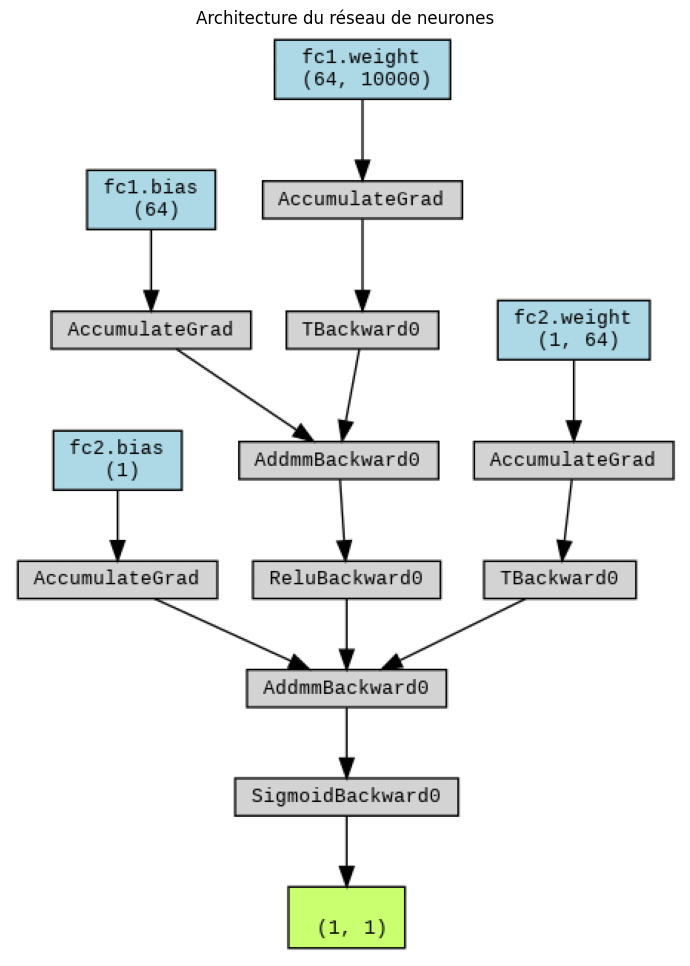

Epoch [1/10], Loss: 0.6984, Val Loss: 0.4189, Val Accuracy: 83.13%
Epoch [2/10], Loss: 0.3729, Val Loss: 0.3217, Val Accuracy: 84.38%
Epoch [3/10], Loss: 0.2469, Val Loss: 0.2718, Val Accuracy: 85.94%
Epoch [4/10], Loss: 0.1747, Val Loss: 0.2353, Val Accuracy: 88.44%
Epoch [5/10], Loss: 0.1268, Val Loss: 0.2053, Val Accuracy: 90.00%
Epoch [6/10], Loss: 0.0936, Val Loss: 0.1799, Val Accuracy: 92.50%
Epoch [7/10], Loss: 0.0702, Val Loss: 0.1584, Val Accuracy: 94.69%
Epoch [8/10], Loss: 0.0531, Val Loss: 0.1406, Val Accuracy: 95.00%
Epoch [9/10], Loss: 0.0403, Val Loss: 0.1258, Val Accuracy: 95.63%
Epoch [10/10], Loss: 0.0307, Val Loss: 0.1133, Val Accuracy: 96.25%


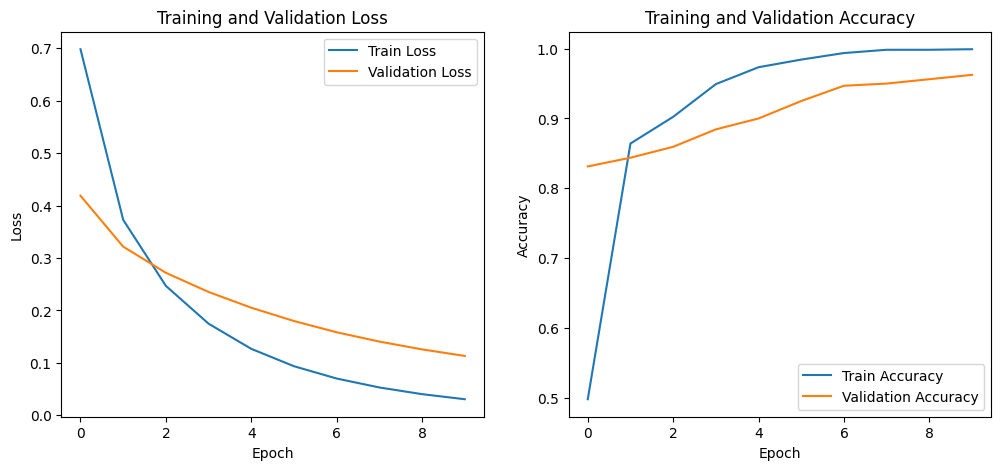

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Préparation des données ---

    # On suppose que votre DataFrame filtrée s'appelle `filtered_data`
X = filtered_data.drop(columns=['Label']).values  # Features (1000 colonnes)
y = filtered_data['Label'].values  # Labels

    # Standardisation des features (important pour les réseaux de neurones)
scaler = StandardScaler()
X = scaler.fit_transform(X)

    # Séparation en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Conversion en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# --- Définition du modèle ---


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # Création de la fonction __init__
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Calcul linéaire PxA + B de l'input à la couche intermédiaire.
        self.relu = nn.ReLU() # transforme en 0-x pour l'activation du neurone (passage des résultats dans une fonction relu)
        self.fc2 = nn.Linear(hidden_size, output_size) # Calcul linéaire PxA + Bde la couche intermédiaire à l'output
        self.sigmoid = nn.Sigmoid() # transforme en 0-1 pour l'activation du neurone(passage des résultats dans une fonction sigmoid)

    def forward(self, x): # Création de la fonction forward, servant à définir comment circule les données dans le réseau.
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


# Lancement de la fonction

input_size = X_train.shape[1]   # 1000 features (taille de l'input ???)
hidden_size = 64                # Taille de la couche cachée
output_size = 1                 # Classification binaire
model = SimpleNN(input_size, hidden_size, output_size)

# --- Visualisation du réseau de neurones ---

  # Installer torchviz et graphviz (nécessaire pour générer et afficher le graphe)
!pip install torchviz
!apt-get install graphviz -y

from torchviz import make_dot

  # Création d'une entrée d'exemple (un seul échantillon)
sample_input = X_train[0].unsqueeze(0)  # Passage d'une dimension batch
sample_output = model(sample_input)

  # Générer le graphe computationnel du modèle
graph = make_dot(sample_output, params=dict(model.named_parameters()))
graph.render("model_architecture", format="png")  # Enregistrement du graphe sous "model_architecture.png"

  # Afficher l'image directement dans le notebook
import matplotlib.image as mpimg
img = mpimg.imread('model_architecture.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title("Architecture du réseau de neurones")
plt.show()

# --- Entraînement du modèle ---

criterion = nn.BCELoss()  # Fonction de perte (binary cross-entropy)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listes pour stocker les valeurs de perte et d'accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass et optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Stocker la perte d'entraînement
    train_losses.append(loss.item())

    # Calcul de l'accuracy sur l'entraînement
    y_train_pred = (outputs > 0.5).float()
    train_accuracy = (y_train_pred == y_train).float().mean()
    train_accuracies.append(train_accuracy.item())

    # Evaluation sur le set de validation
    with torch.no_grad():
        model.eval()
        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val)
        val_losses.append(val_loss.item())

        y_pred_class = (y_pred > 0.5).float()
        accuracy = (y_pred_class == y_val).float().mean()
        val_accuracies.append(accuracy.item())

    # Affichage de l'epoch courante
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item() * 100:.2f}%')

# --- Affichage des courbes d'entraînement ---
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()



In [ ]:
# Get the weights from the first layer (fc1)
weights = model.fc1.weight.data

# Convert to a numpy array for easier manipulation
weights = weights.numpy()

# Calculate the absolute values of the weights (to measure importance)
weights_abs = np.abs(weights)

# Sum the weights across the hidden units to get a single importance value per feature
feature_importance = np.sum(weights_abs, axis=0)

import matplotlib.pyplot as plt
import numpy as np

# Get the feature names (assuming you have them)
feature_names = filtered_data.drop(columns=['Label']).columns


In [ ]:
# Sort features by importance (descending order)
sorted_indices = np.argsort(feature_importance)[::-1]  # Indices of features sorted by importance
sorted_feature_importance = feature_importance[sorted_indices]  # Sorted importance values
sorted_feature_names = feature_names[sorted_indices]  # Sorted feature names

# Select the top n features
top_n = 600
top_feature_importance = sorted_feature_importance[:top_n]
top_feature_names = sorted_feature_names[:top_n]

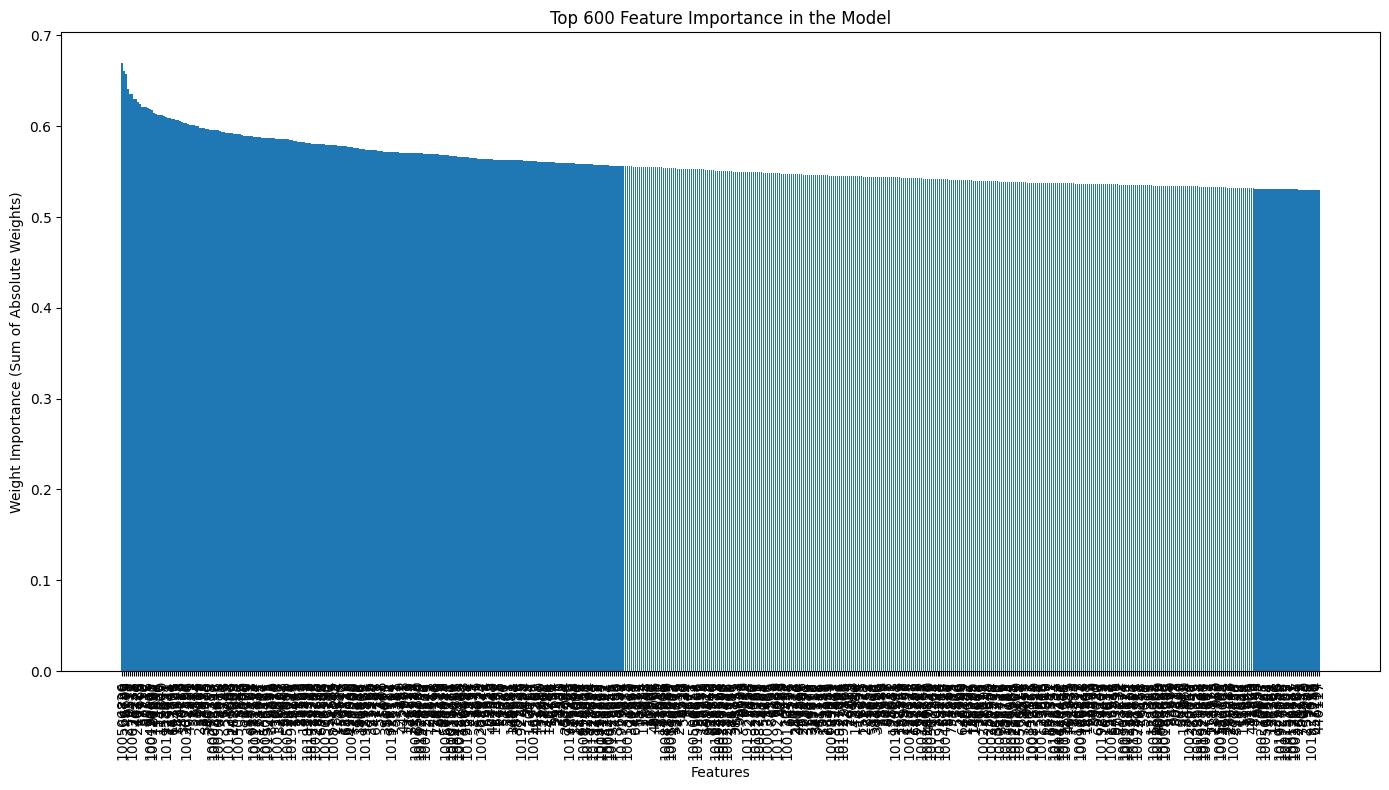

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 1000 features
plt.figure(figsize=(14, 8))
plt.bar(range(top_n), top_feature_importance, align='center')
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight Importance (Sum of Absolute Weights)')
plt.title(f'Top {top_n} Feature Importance in the Model')
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()
